In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from rlxutils import subplots
import rasterio as rio
import netCDF4 as netcfd

from matplotlib.colors import ListedColormap, BoundaryNorm

## Dataset discovery

The cells below will discover what datasets have been downloaded in Notebook 2.

In [2]:
datasets_dir = "./tmp/conus_partitions_aschips_293d95e3ee589"
datasets = os.listdir(datasets_dir)

## get a list of chip ids existing in all datasets

In [3]:
chipids = None
for dataset in datasets:
    z = [i.split(".")[0] for i in os.listdir(f"{datasets_dir}/{dataset}")]
    print(z)
    if chipids is None:
        chipids = z
    else:
        chipids = np.r_[list(set(chipids).intersection(z))]
print(chipids)

['09ffc7ea270d0', '19b15e99d23b9', '2c1a7f33fb7ff', '1ad5de61a0890', '1f9d946cbcfdc', '07c88d8c6881b', '0e00a1efaf0a9', '281bd51f4fb75', '0e4b0d2bdf931']
['09ffc7ea270d0', '19b15e99d23b9', '2c1a7f33fb7ff', '1ad5de61a0890', '1f9d946cbcfdc', '07c88d8c6881b', '0e00a1efaf0a9', '281bd51f4fb75', '0e4b0d2bdf931']
['09ffc7ea270d0', '19b15e99d23b9', '2c1a7f33fb7ff', '1ad5de61a0890', '1f9d946cbcfdc', '07c88d8c6881b', '0e00a1efaf0a9', '281bd51f4fb75', '0e4b0d2bdf931']
['1ad5de61a0890' '0e4b0d2bdf931' '09ffc7ea270d0' '2c1a7f33fb7ff'
 '07c88d8c6881b' '19b15e99d23b9' '1f9d946cbcfdc' '281bd51f4fb75'
 '0e00a1efaf0a9']


## Visualisation

Pick a downloaded chip to visualise. We'll use the first one. Visualisation is implemented for S2RGB, S1GRD and ESAWC in this notebook.

In [4]:
chipid = chipids[0]

### Sentinel-2 RGB

The RGB bands for each the 12 months are visualised below, for the selected chip id.

In [5]:
fname = f"{datasets_dir}/s2rgbm-2020/{chipid}.tif"
d = rio.open(fname)
descrips = np.r_[list(d.descriptions)]
x = d.read()
d.close()
descrips

array(['01_red', '01_green', '01_blue', '02_red', '02_green', '02_blue',
       '03_red', '03_green', '03_blue', '04_red', '04_green', '04_blue',
       '05_red', '05_green', '05_blue', '06_red', '06_green', '06_blue',
       '07_red', '07_green', '07_blue', '08_red', '08_green', '08_blue',
       '09_red', '09_green', '09_blue', '10_red', '10_green', '10_blue',
       '11_red', '11_green', '11_blue', '12_red', '12_green', '12_blue'],
      dtype='<U8')

In [6]:
# values are ints in the 0-255 range
x = np.transpose(x, (1,2,0))
x.shape, x.min(), x.max()

((448, 448, 36), 0, 255)

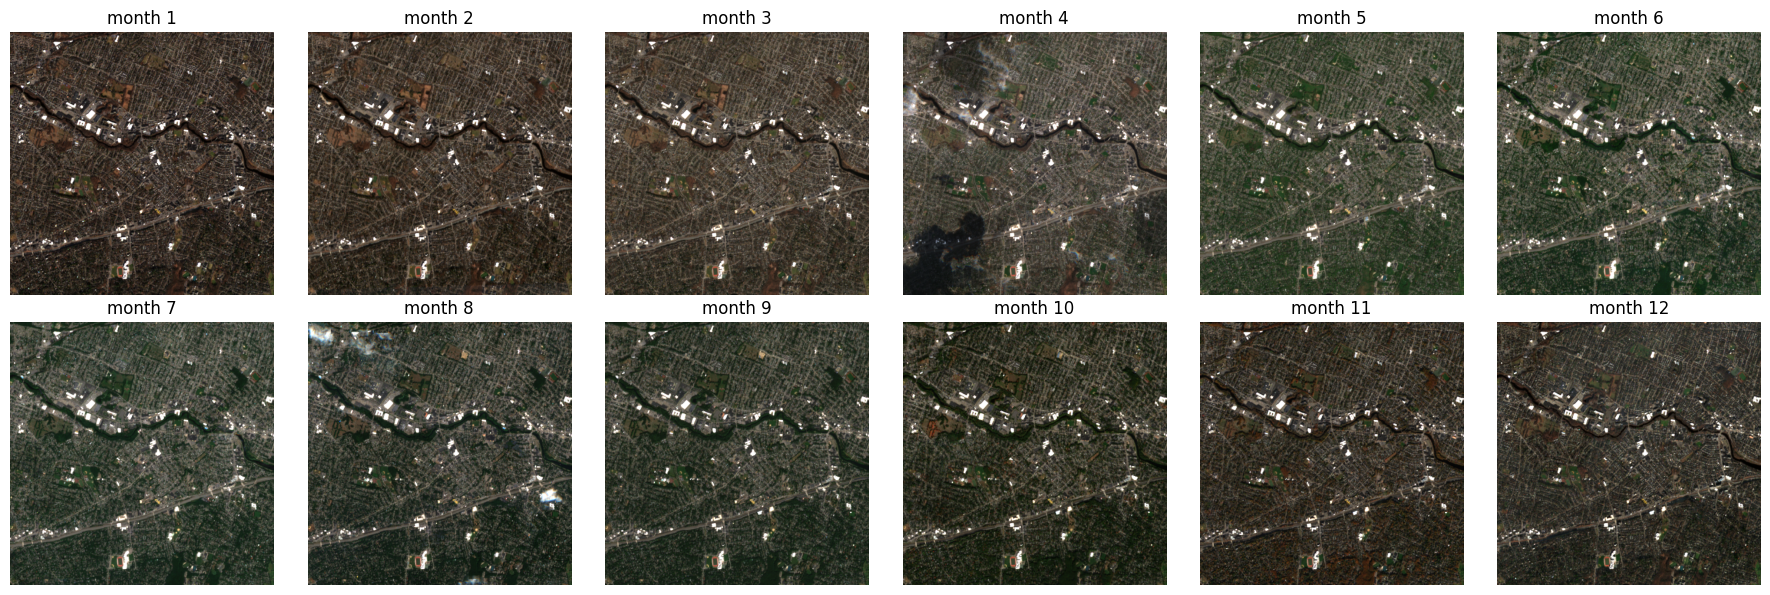

In [7]:
for ax,i in subplots(12, n_cols=6):
    plt.imshow(x[:,:,i*3:(i+1)*3])
    plt.title(f"month {i+1}")
    plt.axis('off')

### Sentinel 1 GRD (SAR Polarimetric Amplitude)

Visualised below. This region has good coverage for both polarisations (VV+VH), as well as both orbital directions (Ascending, Descending)

In [8]:
fname = f"{datasets_dir}/s1grd-2020/{chipid}.tif"
d = rio.open(fname)
x = d.read().astype(np.uint8)
descrips = np.r_[list(d.descriptions)]
d.close()
print(descrips)

['winter_vvasc' 'winter_vvdes' 'winter_vhasc' 'winter_vhdes'
 'spring_vvasc' 'spring_vvdes' 'spring_vhasc' 'spring_vhdes'
 'summer_vvasc' 'summer_vvdes' 'summer_vhasc' 'summer_vhdes' 'fall_vvasc'
 'fall_vvdes' 'fall_vhasc' 'fall_vhdes']


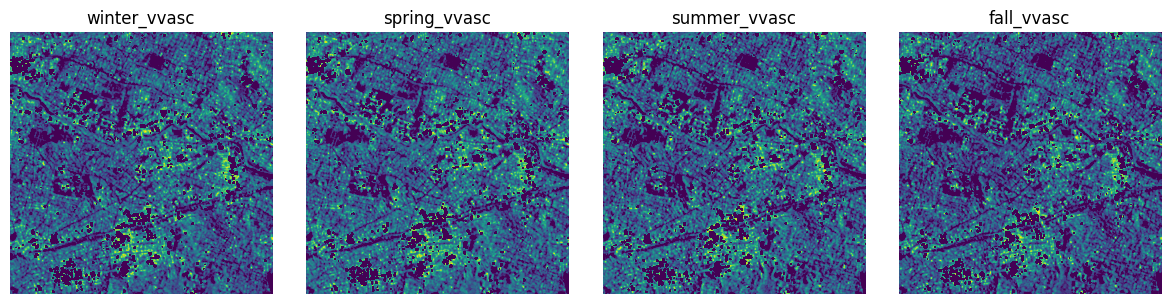

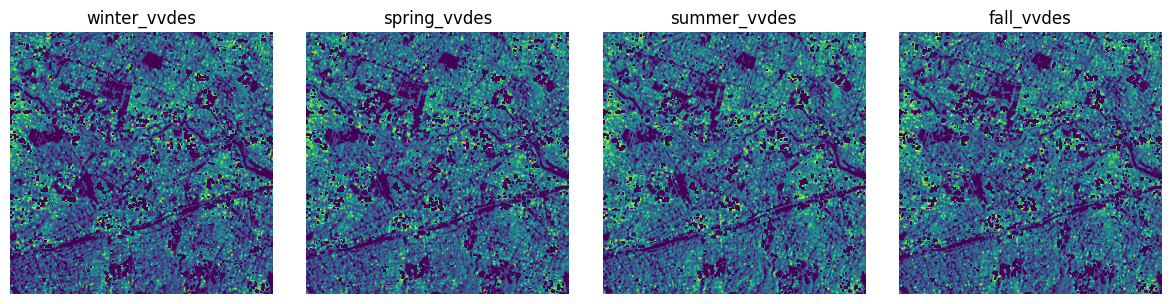

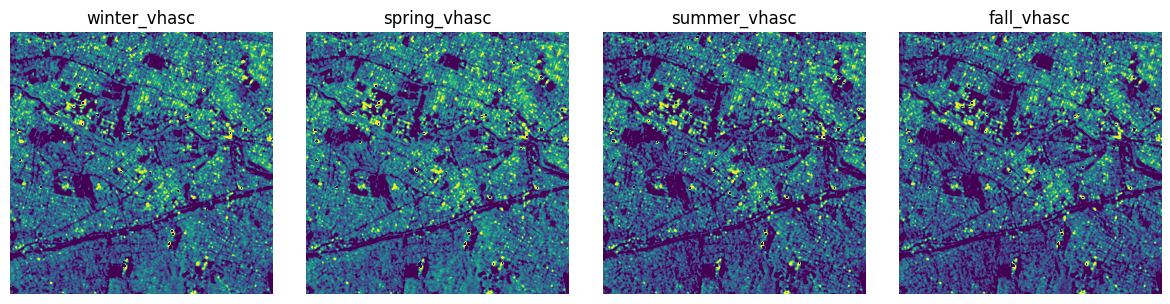

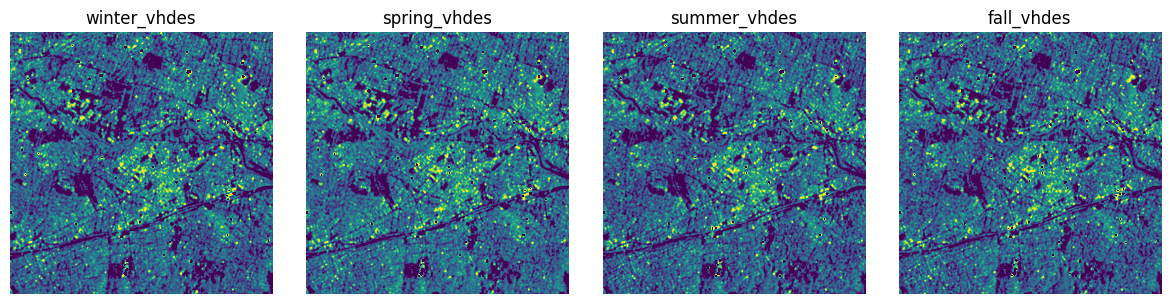

In [9]:
mode = 'vvasc'

for mode in ['vvasc', 'vvdes', 'vhasc', 'vhdes']:
    channels = np.argwhere([mode in i for i in descrips])[:,0]
    a,b = np.percentile(x[channels], [10,99])
    for ax,i in subplots(channels):
        plt.imshow(x[i], vmin=a, vmax=b)
        plt.title(descrips[i])
        plt.axis('off')

### ESAWC

Finally, the 11 class semantic segmentation dataset, ESA World Cover. The pixel values for each class are:

| Pixel Value | Class                    |
|-------------|--------------------------|
| 10          | Tree Cover               |
| 20          | Shrubland                |
| 30          | Grassland                |
| 40          | Cropland                 |
| 50          | Built-up                 |
| 60          | Bare/Sparse Vegetation   |
| 70          | Snow and Ice             |
| 80          | Permanent Water Bodies   |
| 90          | Herbaceous Wetland       |
| 95          | Mangroves                |
| 100         | Moss and Lichen          |


In [10]:
fname = f"{datasets_dir}/esaworldcover-2020/{chipid}.tif"
d = rio.open(fname)
descrips = np.r_[list(d.descriptions)]
x = d.read()
d.close()
descrips, x.shape

(array(['Map'], dtype='<U3'), (1, 448, 448))

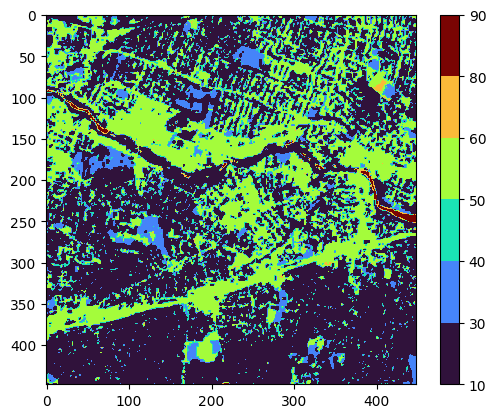

In [11]:
values = np.unique(x[0])
colors = plt.cm.turbo(np.linspace(0, 1, len(values)))
cmap = ListedColormap(colors)

norm = BoundaryNorm(values, cmap.N)

plt.imshow(x[0], cmap=cmap, norm=norm)

plt.colorbar(ticks=values)